In [3]:
import research
from datetime import datetime, timezone, timedelta

def research_linreg(sym, interval, no_lags, features):
    end_time = datetime.now(timezone.utc)
    start_time = end_time - timedelta(days=365 * 1)

    df = research.create_ar_df(sym, interval, start_time, end_time, no_lags)
    research.eval_linreg(df, features, 'close_log_return')


dl_ohlc(BTC,1m, 2024-12-31 16:03:37.374164+00:00, 2025-12-31 16:03:37.374164+00:00)
Model coefficients: [0.02139487] + 1.770095626999765e-05
Win rate: 0.459
Total return: -0.008


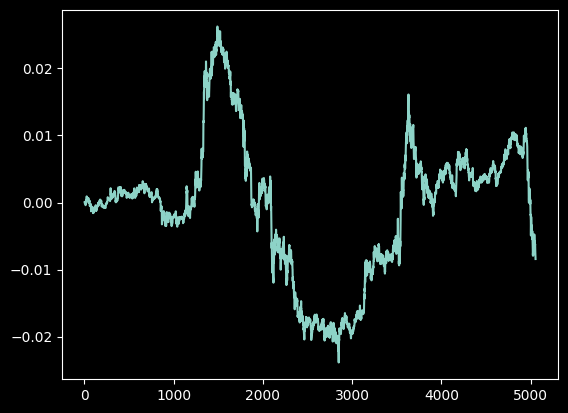

In [4]:
research_linreg('BTC','1m', 1, ['close_log_return_lag_1'])